# Testing the 'Flow Matching in 100 LOC'-code and augmenting it with Bayesian Methods

In [1]:
import torch
import torch.nn as nn
from torch import Tensor
from torch.distributions import Normal

import sys
sys.path.append('./models/') 

from cond_CFM import CNF, FlowMatchingLoss

import numpy as np
import normflows as nf
import os
from tqdm import tqdm
from typing import *
from zuko.utils import odeint

from matplotlib import pyplot as plt

from jet_dataset import JetDataset

from typing import *
from zuko.utils import odeint

In [2]:
def smooth(x, kernel_size=5):
    if kernel_size == 1:
        return x
    else:
        assert kernel_size % 2 != 0
        x_shape = x.shape
        x_tmp = np.array([x[i:x_shape[0]-kernel_size+i+1] for i in range(kernel_size)])
        edge1 = x[:int((kernel_size-1)/2)]
        edge2 = x[-int((kernel_size-1)/2):]
        x_out = np.concatenate((edge1, np.mean(x_tmp, 0),edge2),0)
        assert x_shape == x_out.shape
        return x_out #np.mean(np.array(x).reshape(-1, kernel_size),1)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
save_dir = './data/CFM_jets15/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [5]:
#######################
### Define the data ###
#######################

batch_size = 131072

dont_use = 'jet_nparticles', 'jet_sdmass	jet_tau1	jet_tau2	jet_tau3	jet_tau4	aux_genpart_eta	aux_genpart_phi	aux_genpart_pid	aux_genpart_pt	aux_truth_match')

dataset = JetDataset("./jet_data",'train', del_context=dont_use)
dataset_val = JetDataset("./jet_data",'val, del_context=dont_use)')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=10)

In [6]:
###################################
### Define the Normalizing Flow ###
###################################

# Construct flow model
model = CNF(1, conds = dataset.features.shape[1])#, n_nodes=[256] * 3)

# Move model on GPU if available
model = model.to(device)


In [9]:
#####################
### Training Loop ###
#####################

train = True
lr = 1e-3
weight_decay = 0 
lr_decay = 1 #0.999

epochs = 200

if train:
    cfm_loss = FlowMatchingLoss(model)
    optim = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, lr_decay)
    model.train()

    loss_hist = np.array([])

    for ep in tqdm(range(epochs)):
        optim.zero_grad()
        
        for x, c in dataloader:
            optim.zero_grad()
            x = x.to(device)
            c = c.to(device)
            
            # Compute loss
            loss = cfm_loss(x, c)
            
            # Do backprop and optimizer step
            if ~(torch.isnan(loss) | torch.isinf(loss)):
                loss.backward()
                optim.step()
                scheduler.step()
            
        # Log loss
        loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

        if ep%50 == 0:
            torch.save(model.state_dict(), save_dir + f"model_{ep}.pth")


# # Sampling
# with torch.no_grad():
# z = torch.randn(4096, 2)
# x = flow.decode(z).numpy()


# # Log-likelihood
# with torch.no_grad():
# log_p = flow.log_prob(data[:4])

    model.eval()

    torch.save(model.state_dict(), save_dir + f"model_{ep}.pth")
    print('saved model at ' + save_dir + f"model_{ep}.pth")

else:
    ep = epochs-1

    with open(save_dir + f'losses_{ep}.npy', 'rb') as f:
        loss_hist = np.load(f)

    model.load_state_dict(torch.load(save_dir + f"model_{ep}.pth"))
    print('loaded model from ' + save_dir + f"model_{ep}.pth")


# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(smooth(loss_hist,1), color = 'C1', alpha = 0.3)
plt.plot(smooth(loss_hist,11), label='loss', color = 'C1')
plt.grid()
plt.legend()
img_outfile = save_dir + f"image_ep{ep}_loss.png"
plt.savefig(img_outfile)
plt.show()

  4%|▎         | 7/200 [00:57<26:37,  8.28s/it]


KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
    d = torch.Tensor(dataset_val.features[:1000]).to(device)
    z = torch.randn(len(d), 1).to(device)
    x_gen_raw = model.decode(z, cond=d).detach().cpu().numpy()*20

plotting raw (1000000, 1) (1000000, 1)
plotting raw gen


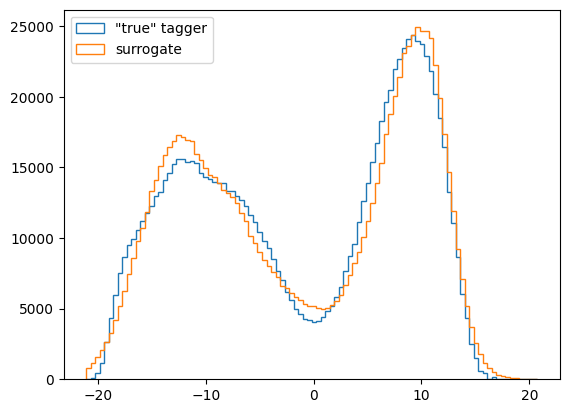

saved images at ./data/CFM_jets15/


In [ ]:
print("plotting raw", dataset_val.target.shape, x_gen_raw.shape)
_,b,_ = plt.hist(dataset_val.target[:,0]*20.,bins=100, label='"true" tagger',histtype='step')
print("plotting raw gen")
plt.hist(x_gen_raw[:,0],bins=b, label='surrogate',histtype='step')
plt.legend()
img_outfile = save_dir + f"image_ep{ep}_raw.png"
plt.savefig(img_outfile)
plt.show()
print('saved images at ' + save_dir)

In [ ]:
################
### Plotting ###
################

from sklearn.metrics import roc_curve

with torch.no_grad():
    # get a batch to compare
    conditions = torch.Tensor(dataset_val.features).to(device)
    
    bs = 1000 
    n_bs = len(conditions)//bs+1

    c_new = conditions[:bs]
    x_gen, _ = model.sample(bs, context=conditions[:bs])
    for i in range(n_bs-1):
        c_data = conditions[(i+1)*bs:(i+2)*bs]
        c_new = torch.concat((c_new, c_data), 0)
        x_gen_tmp, _ = model.sample(len(c_data), context=c_data)
        x_gen = torch.concat((x_gen, x_gen_tmp), 0)

    conditions = c_new
    x_gen = x_gen*20. #back to full scale
    x_gen_raw = x_gen #HIER SOLLTE NOCH GEMITTELT WERDEN ÜBER OUTPUTS ZUR SELBEN CONDITION
    x_gen = torch.sigmoid(x_gen)
    print("plotting rocs")
    fpr,tpr,_ = roc_curve(dataset_val.truth, dataset_val.raw_target)
    gfpr,gtpr,_ = roc_curve(dataset_val.truth, x_gen.cpu())
    plt.plot(tpr, fpr, label='"true" tagger')
    plt.plot(gtpr, gfpr, label='surrogate')
    plt.xlabel("Efficiency")
    plt.ylabel("Fake rate")
    plt.legend()
    img_outfile = save_dir + f"image_ep{ep}.png"
    plt.savefig(img_outfile)

    plt.yscale('log')
    img_outfile = save_dir + f"image_ep{ep}_log.png"
    plt.savefig(img_outfile)
    plt.show()

    print("plotting raw", dataset_val.target.shape, x_gen_raw.shape)
    _,b,_ = plt.hist(dataset_val.target[:,0]*20.,bins=100, label='"true" tagger',histtype='step')
    print("plotting raw gen")
    plt.hist(x_gen_raw.cpu().numpy()[:,0],bins=b, label='surrogate',histtype='step')
    plt.legend()
    img_outfile = save_dir + f"image_ep{ep}_raw.png"
    plt.savefig(img_outfile)
    plt.show()
    print('saved images at ' + save_dir)